In [1]:
%matplotlib inline
import sys
sys.path.append('../code')

from plotutils import *

In [2]:
"""
Load the tap brain model
"""

fname = 'Ns_5_noiseseed_0'
use_cuda = True
tapbrain, theta, params = loadbrain('../data/brains/' + fname, use_cuda)

In [3]:
"""
Generate measurements
"""
T_clip = 20
B, T = 25, 50

y, x, r_brain = [], [], []
gainy = np.linspace(0.5,5,B)

for b in range(B):
    params['gain_y'] = gainy[b]
    y1, x1, r_brain1 = generatedata(tapbrain, theta, params, use_cuda, 1, T, T_clip)
    y.append(y1.squeeze())
    x.append(x1.squeeze())
    r_brain.append(r_brain1.squeeze())
    
del x1, y1, r_brain1
x = np.stack(x).transpose(1,2,0)
y = np.stack(y).transpose(1,2,0)
r_brain = np.stack(r_brain).transpose(1,2,0)

# Add independent noise to neural activity
q_obs   = 0.04
r_brain = r_brain + np.sqrt(q_obs)*np.random.randn(r_brain.shape[0], T, B)

In [4]:
"""
Run the particle filter with numpy code
"""
Ns = params['Ns']
Nr = params['Nr']
Ny = params['Ny']
q_process = 1e-6
Np        = 100

params['Q_obs']     = q_obs*np.eye(Nr)
params['Q_process'] = q_process*np.eye(Ns)
params['Np']        = Np

t_st = time.time()
LL_tp, x_tp, r_tp, P_tp, W_tp = runparticlefilter(r_brain, y, theta, params)
t_en = time.time()

print('Log likelihood with true parameters = ', LL_tp.mean())
print('time elapsed =', round(100*(t_en - t_st))/100, 's')

"""
Perturb theta
"""
theta_true = np.copy(theta)

lam, G, J, U, V = extractParams(theta, 18, params['Ns'], params['Ny'], params['Nr'])

G  *= 0
dJ = 1*np.random.randn(Ns,Ns); dJ = (dJ + dJ.T)/2
J  += dJ
V  += 1*np.random.randn(Ns,Ny) 

theta = np.concatenate([np.array([lam]), G, JMatToVec(J), U.flatten('F'), V.flatten('F')])

LL_tp, x_tp, r_tp, P_tp, W_tp = runparticlefilter(r_brain, y, theta, params)
print('Log likelihood with perturbed parameters in numpy code = ', LL_tp.mean())

Log likelihood with true parameters =  -270.4720006520909
time elapsed = 0.78 s
Log likelihood with perturbed parameters in numpy code =  -2433.797539981248


In [5]:
computegrad = np.array([1,1,1,1,0],dtype=int)
t_st = time.time()
C = runNegLL(theta, r_brain, y, P_tp, W_tp, params, computegrad, 0, 0)
t_en = time.time()
print(C)
print('time elapsed =', round(100*(t_en - t_st))/100, 's')

79966.65628281272
time elapsed = 0.32 s


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

Q_process = q_process*torch.eye(params['Ns'],device=device,dtype=dtype)
Q_obs     = q_obs*torch.eye(params['Nr'],device=device,dtype=dtype)

r = torch.tensor(r_brain,device=device,dtype=dtype)
y = torch.tensor(y,device=device,dtype=dtype)
r = r.permute(2,0,1)
y = y.permute(2,0,1)

G_true, J_true, U_true, V_true = extractParams(theta_true, 18, params['Ns'], params['Ny'], params['Nr'])[1:]

lam, G, J, U, V = extractParams(theta, 18, params['Ns'], params['Ny'], params['Nr'])

G_init = np.copy(G)
J_init = np.copy(J)
U_init = np.copy(U)
V_init = np.copy(V)

lam = torch.tensor(lam,device=device,dtype=dtype,requires_grad=False)
G = torch.tensor(G,device=device,dtype=dtype,requires_grad=True)
J = torch.tensor(J,device=device,dtype=dtype,requires_grad=True)
U = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V = torch.tensor(V,device=device,dtype=dtype,requires_grad=True)

In [7]:
t_st = time.time()
with torch.no_grad():
    LL, xhat, ParticlesAll, WVec = particlefilter_torch(G, J, U, V, lam, r, y, Q_process, Q_obs, Np, device, dtype)
t_en = time.time()
print('Log likelihood with torch code = ', LL.mean())
print('time elapsed =', round(100*(t_en - t_st))/100, 's')

Log likelihood with torch code =  tensor(-2433.6057)
time elapsed = 0.57 s


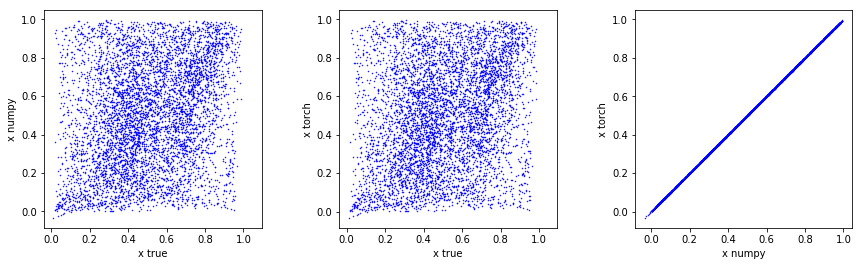

In [8]:
xhat_ = xhat.permute(1,2,0).data.numpy()

t_st = 6

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(x[:,t_st:].flatten(),x_tp[:,t_st:].flatten(),'b.',markersize=1)
ax[0].axis('square')
ax[0].set_xlabel('x true'); ax[0].set_ylabel('x numpy')
ax[1].plot(x[:,t_st:].flatten(),xhat_[:,t_st:].flatten(),'b.',markersize=1)
ax[1].axis('square')
ax[1].set_xlabel('x true'); ax[1].set_ylabel('x torch')

ax[2].plot(x_tp[:,t_st:].flatten(),xhat_[:,t_st:].flatten(),'b.',markersize=1)
ax[2].axis('square')
ax[2].set_xlabel('x numpy'); ax[2].set_ylabel('x torch')

plt.show()

In [9]:
P_tp_ = torch.tensor(P_tp,device=device,dtype=dtype).permute(3,0,1,2)
W_tp_ = torch.tensor(W_tp,device=device,dtype=dtype).permute(1,0)

t_st = time.time()
C    = Qfunction_torch(G, J, U, V, lam, r, y, P_tp_, W_tp_, Q_process, Q_obs, device, dtype)
t_en = time.time()
print(C.item())
print('time elapsed =', round(100*(t_en - t_st))/100, 's')

79966.65625
time elapsed = 0.13 s


In [10]:
# Run PF-EM

lrate     = 4e-2
params    = [G, J, V]
optimizer = torch.optim.Adam(params,lr=lrate, betas=(0.9, 0.999))
NEpochs   = 400
LLVec     = []

t_st      = time.time()

for epoch in range(NEpochs):
    optimizer.zero_grad() # zero-gradients at the start of each epoch
    
    # E-step
    C = Qfunction_torch(G, J, U, V, lam, r, y, ParticlesAll, WVec, Q_process, Q_obs, device, dtype)
    
    # M-step
    C.backward()

    optimizer.step()
    
    # Run PF again to get posterior for E-step
    with torch.no_grad():
        LL, xhat, ParticlesAll, WVec = particlefilter_torch(G, J, U, V, lam, r, y, Q_process, Q_obs, Np, device, dtype)
        
    LLVec.append(LL.mean())
    
    if (epoch+1) % 50 == 0:
        print('[%d] training loss: %.5f' %(epoch + 1, LL.mean()))
        
t_en = time.time()

print('Finished training')
print('Time elapsed =', np.round(1000*(t_en - t_st))/1000, 's')

[50] training loss: -688.59174
[100] training loss: -329.72177
[150] training loss: -269.63977
[200] training loss: -266.02991
[250] training loss: -263.99655
[300] training loss: -264.97714
[350] training loss: -266.80368
[400] training loss: -264.70212
Finished training
Time elapsed = 180.675 s


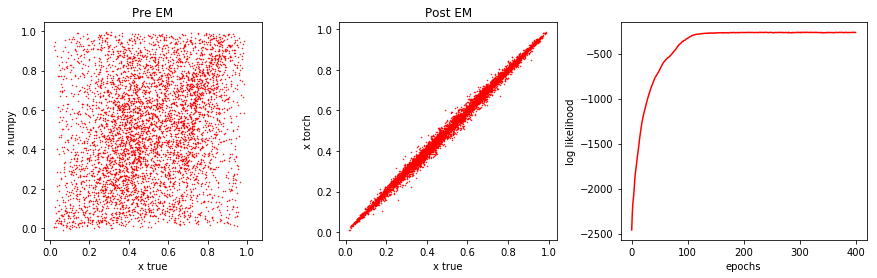

In [11]:
xhat_ = xhat.permute(1,2,0).data.numpy()

t_st = 10

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(x[:,t_st:].flatten(),x_tp[:,t_st:].flatten(),'r.',markersize=1)
ax[0].axis('square')
ax[0].set_xlabel('x true'); ax[0].set_ylabel('x numpy')
ax[0].set_title('Pre EM')
ax[1].plot(x[:,t_st:].flatten(),xhat_[:,t_st:].flatten(),'r.',markersize=1)
ax[1].axis('square')
ax[1].set_xlabel('x true'); ax[1].set_ylabel('x torch')
ax[1].set_title('Post EM')

LLVec_ = torch.stack(LLVec).data.cpu().numpy()
ax[2].plot(LLVec_,'r')
ax[2].set_xlabel('epochs'); ax[2].set_ylabel('log likelihood')
plt.show()

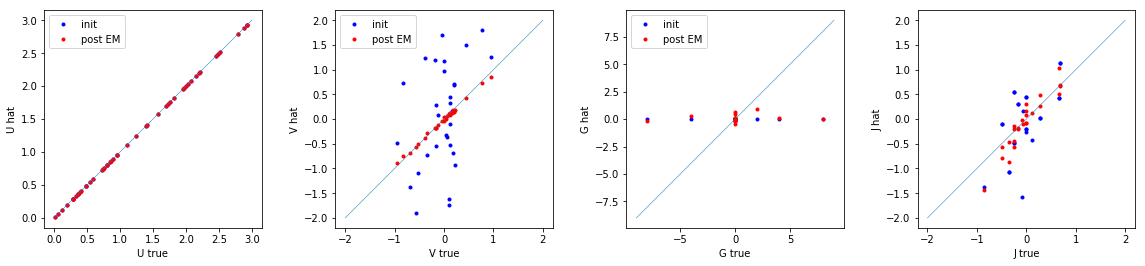

In [12]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(U_true.flatten(),U_init.flatten(),'b.')
ax[0].plot(U_true.flatten(),U.data.numpy().flatten(),'r.')
ax[0].set_xlabel('U true'); ax[0].set_ylabel('U hat'); ax[0].legend(['init','post EM'])
ax[0].plot([0,3],[0,3],linewidth=0.5)
ax[0].axis('square')

ax[1].plot(V_true.flatten(),V_init.flatten(),'b.')
ax[1].plot(V_true.flatten(),V.data.numpy().flatten(),'r.')
ax[1].set_xlabel('V true'); ax[1].set_ylabel('V hat'); ax[1].legend(['init','post EM'])
ax[1].plot([-2,2],[-2,2],linewidth=0.5)
ax[1].axis('square')

ax[2].plot(G_true, G_init,'b.')
ax[2].plot(G_true, G.data.numpy().flatten(),'r.')
ax[2].set_xlabel('G true'); ax[2].set_ylabel('G hat'); ax[2].legend(['init','post EM'])
ax[2].plot([-9,9],[-9,9],linewidth=0.5)
ax[2].axis('square')

ax[3].plot(J_true.flatten(),J_init.flatten(),'b.')
ax[3].plot(J_true.flatten(),J.data.numpy().flatten(),'r.')
ax[3].set_xlabel('J true'); ax[3].set_ylabel('J hat'); ax[1].legend(['init','post EM'])
ax[3].plot([-2,2],[-2,2],linewidth=0.5)
ax[3].axis('square')

plt.show()

[10, 41, 0, 1]

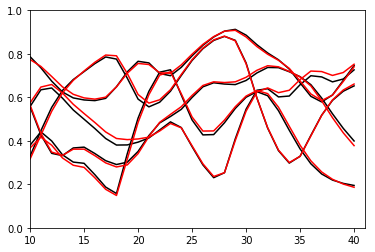

In [13]:
k, b = 2, 11
plt.plot(x[:,t_st:,b].T,'k')
plt.plot(xhat_[:,t_st:,b].T,'r')
plt.axis([t_st,51-t_st,0,1])